In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-vs-human-text/AI_Human.csv
/kaggle/input/ai_vs_human/keras/default/1/ai_vs_human_model.keras


In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "AI_Human.csv"
print(f"Attempting to load file: {file_path}")

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shanegerami/ai-vs-human-text",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Attempting to load file: AI_Human.csv


/tmp/ipykernel_5566/2694465807.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                                 text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

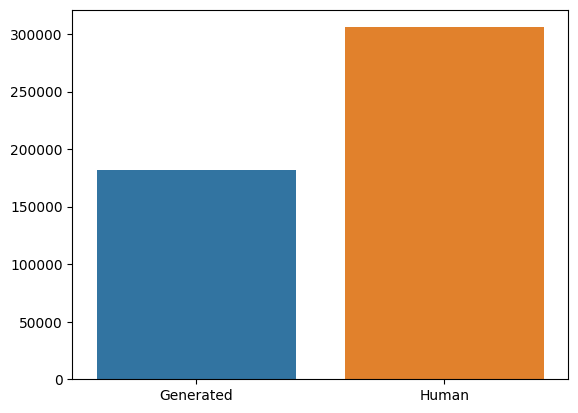

In [5]:
import seaborn as sns
sns.barplot(x=['Generated', 'Human'], y=[len(df[df['generated'] == 1]), len(df[df['generated'] == 0])])

In [6]:
print(len(df[df['generated'] == 1]))
print(len(df[df['generated'] == 0]))

181438
305797


In [3]:
# Get the number of samples in the minority class (generated == 1)
minority_class_count = len(df[df['generated'] == 1])

# Separate the majority and minority classes
df_majority = df[df['generated'] == 0]
df_minority = df[df['generated'] == 1]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=minority_class_count, random_state=42) # Using random_state for reproducibility

# Concatenate the minority class and the undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Display the number of samples in the balanced dataset for each class
print("Balanced dataset shape:", df_balanced.shape)
print("Number of samples in each class in the balanced dataset:")
print(df_balanced['generated'].value_counts())

# Display the first few rows of the balanced dataset
print("\nFirst 5 records of the balanced dataset:")
display(df_balanced.head())

Balanced dataset shape: (362876, 2)
Number of samples in each class in the balanced dataset:
generated
0.0    181438
1.0    181438
Name: count, dtype: int64

First 5 records of the balanced dataset:


,text,generated
260481,Do curfews keep teenagers from Getting into tr...,0.0
133303,"In this article ""The Challenge of Exploring Ve...",0.0
291551,With THP rapid growth of THP Internet in recen...,0.0
451335,The electoral College is the way Us United Sta...,0.0
461660,This technology of you can calculate the emoti...,0.0


In [6]:
df_balanced.to_csv('AI_Human_balanced_dataset.csv', index=False)

In [4]:
from tensorflow.keras.layers import TextVectorization

2025-09-07 14:46:52.632252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757256412.802558    5566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757256412.850770    5566 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
X = df_balanced['text']
y = df_balanced['generated'].values

In [6]:
MAX_FEATURES = 200000

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

I0000 00:00:1757255830.332218    1758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [13]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(128) #we batched up the data
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
callback=EarlyStopping(monitor="accuracy",patience=7,restore_best_weights=True)

model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
# Final layer
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
history = model.fit(train, epochs=10, validation_data=val,callbacks=callback)

Epoch 1/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 356s 174ms/step - accuracy: 0.9956 - loss: 0.0199 - val_accuracy: 0.9951 - val_loss: 0.0086
Epoch 2/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 340s 171ms/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.9977 - val_loss: 0.0043
Epoch 3/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 339s 171ms/step - accuracy: 0.9985 - loss: 0.0070 - val_accuracy: 0.9986 - val_loss: 0.0033
Epoch 4/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 338s 170ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 5/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 338s 170ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 6/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 337s 170ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9975 - val_loss: 0.0060
Epoch 7/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 338s 170ms/step - accuracy: 0.9991 - loss: 0.0046 - val_accuracy: 0.9983 - val_loss: 0.0038
Epoch 8/100
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 337s 170ms/s

KeyboardInterrupt: 

In [24]:
model.save("ai_vs_human_model.keras")

In [53]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 500)            │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,484,557 (78.14 MB)

 Trainable params: 6,828,185 (26.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,656,372 (52.09 MB)

In [8]:
from tensorflow.keras.models import load_model

In [9]:
model = load_model("ai_vs_human_model.keras")

I0000 00:00:1757256442.494463    5566 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [25]:
import pickle

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [20]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision() #This is done in this way in tf
re = Recall()     #By doing this we will get aggregrate result of all the batches
acc = CategoricalAccuracy() #as we are sending data in batches

In [21]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten() #Flatting for better metric evaluation
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━

In [22]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 1.0, Recall:0.4568518102169037, Accuracy:0.06360424309968948


In [10]:
import pickle

# Load the vectorizer
with open('vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

In [11]:
loaded_vectorizer.adapt(X.values)
vectorized_text = loaded_vectorizer(X.values)

NameError: name 'tf' is not defined

In [12]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(128) #we batched up the data
dataset = dataset.prefetch(8) # helps bottlenecks

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [13]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision() #This is done in this way in tf
re = Recall()     #By doing this we will get aggregrate result of all the batches
acc = CategoricalAccuracy() #as we are sending data in batches

In [52]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    #y_true = y_true.flatten() #Flatting for better metric evaluation
    #yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━

In [ ]:
gendf = df_balanced[df_balanced['generated'] == 1]
display(gendf.head())

In [37]:
humdf = df_balanced[df_balanced['generated'] == 0]

In [49]:
humdf['text'].iloc[753]

'Do you have something you are good at, like a hobby or a skill? Hobbies can range from musical theater, to art, sports, cooking, and to gaming! Some people have several hobbies, while others focus on just one. Some people find their interests and hobbies easily, but others take time, and may need a little push from their parents or their school. Trying something new can be difficult, but with the new policy the principal established regarding participating in at least one extracurricular activity, it is a great opportunity to get started on and have fun with participating in something new.\n\nThe benefits of trying a new a hobby or extracurricular are numerous. One of the effects of this new policy is that students can easily find something that they can be focused on, interested in, and invested in. Through that certain activities, they may find that it is beneficial to their health, like sports, or beneficial to learning life skills, like cooking. Students also have the chance to ga

In [34]:
gendf['text'].iloc[7]

'  The Path to Sustainable Urban Living  In an age of rapid urbanization, the concept of car-free cities is gaining momentum as a visionary solution to the complex challenges posed by urban areas. Car-free cities are urban environments where private automobiles are either heavily restricted or completely prohibited, promoting the use of sustainable transportation alternatives and fostering a healthier, more vibrant urban lifestyle. This essay explores the concept of car-free cities, examining the potential benefits, challenges, and strategies for their successful implementation.  Car-free cities offer a vision of urban living focused on sustainability and well-being:  Environmental Sustainability: By significantly reducing the number of cars on the road, car-free cities contribute to cleaner air and a reduction in greenhouse gas emissions, thus playing a vital role in mitigating climate change.  Public Health: These cities prioritize pedestrian and cyclist safety, leading to fewer acci

In [51]:
import tensorflow as tf

input_text = loaded_vectorizer("Do you have something you are good at, like a hobby or a skill? Hobbies can range from musical theater, to art, sports, cooking, and to gaming! Some people have several hobbies, while others focus on just one. Some people find their interests and hobbies easily, but others take time, and may need a little push from their parents or their school. Trying something new can be difficult, but with the new policy the principal established regarding participating in at least one extracurricular activity, it is a great opportunity to get started on and have fun with participating in something new. The benefits of trying a new a hobby or extracurricular are numerous. One of the effects of this new policy is that students can easily find something that they can be focused on, interested in, and invested in. Through that certain activities, they may find that it is beneficial to their health, like sports, or beneficial to learning life skills, like cooking. Students also have the chance to gain social skills, and create new friendships and friend groups\xa0through extracurricular activities. Another effect of the mandatory extracurricular policy is that students may develop new appreciation for the school and the faculty who work there, as they discover that teachers can juggle teaching school subjects as well as organizing and managing clubs or other activities. Above all, students overall mood and their mood towards school may shift, as they have found an aspect of school they enjoy. Their mood might also be changed because they look forward to their extracurricular, for they have the chance to participate in something interesting to them, something they are interested in learning, or something they are already good at. Students could also be excited to master the skill or subject, communicate and work with their friends, and make connections around the school whether with fellow students or faculty.\n\nParents may also find benefits of the new extracurricular policy. They may find that their child is more attentive and focused at school, and their report card and grades may be showing improvement because they have joined an after school activity. This is because they have most likely formed a bond with a few of their teachers through extracurricular activities, and student may have more motivation to do better in those particular classes, plus they may find it easier to speak with their teachers and approach them for help. Parents may also notice that their child is less inactive, or perhaps less lazy, because their extracurricular has motivated them to do a similar activity or an activity related to the club at home. Finally, parents will most likely be supportive of this policy because the club or activity will keep their child busy for a few extra hours after school, meaning that the parents may be able to work a few hours more because they don\'t have the responsibility of taking care of their child.\n\nTeachers may also be able to profit off of this policy for a few different reasons. One of those reasons would be that teachers would gain more respect from students, and would be able to spend their time in class more efficiently, as students would most likely be respectful of them teaching, and would not waste class time\xa0being disruptive.\n\nAlthough there are many benefits of the mandatory extracurricular activity policy, there may also be a few drawbacks. One drawback would be for students, in that they would have less time for homework, and completing projects and assignments teachers have assigned for them to do at home. Another drawback for students would be that they may already have commitments outside of school, such as dancing at a dance studio, or taking at classes at a craft store. A problem for parents might be that after school\xa0buses aren\'t available, and they have to pick up their child from their after school\xa0activity, which may be an issue for their schedule, or they are unable to pick their child up because of work. A drawback for faculty or teacher would be that the student may be almost too excited about their extracurricular, and they attempt to rush their assignments and classwork, so then they are able to finish faster and go to their activity faster. Another possibility is that students wouldn\'t be focused on school, because they are thinking about their after school club. One last drawback would be that students might not like the extracurricular activity policy, and would not want to have fun doing it, because they seem like it is forced and unfair because it is mandatory. However, all these issues have viable solutions. For example, as solution to the issue regarding already having extracurricular activities out of school could be that there could be an op tout form for people with outofschool commitments that students and their parents would have to sign so the could spout of the extracurricular policy. One plausible solution to the transport problem for parents who work is the faculty of the school could advise students who live near the school to walk or bike home, that way there would be fewer kids needing the transport of a bus, and less demand for a bus would mean that the school could afford buses each day because of having less buses overall. The drawback regarding students having less time for homework and other assignments could be that there could be a club for homework where students could meet up and work together on homework with the assistance of teachers. Another solution to the following problem would be that teachers could help students use their time wisely during study hall to finish homework.\n\nThere are several\xa0effects of the extracurricular activity rule, although most effects are positive, and all the negative outcomes of the policy have solutions that the administrative council could easily adhere to. Overall, I would fully support\xa0this policy because it could be beneficial to the entire school community, students, parents, and faculty")
# Add an extra dimension to make it a batch of size 1
input_text = tf.expand_dims(input_text, axis=0)
res = model.predict(input_text)
(res > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


array([[0]])

In [47]:
df_balanced['generated'].info()

<class 'pandas.core.series.Series'>
Index: 362876 entries, 260481 to 487232
Series name: generated
Non-Null Count   Dtype  
--------------   -----  
362876 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB
